# Lab Work 10 : NLP Basics

This notebook builds on the tenth lecture of Foundations of Machine Learning. We'll focus on some _traditionnal_ NLP technics, meaning not using any _transformer_ architectures.

Important note: the steps shown here are not always the most efficient or the most "industry-approved." Their main purpose is pedagogical. So don't panic if something looks suboptimal—it's meant to be.

If you have questions (theoretical or practical), don't hesitate to bug your lecturer.

We will try to accurately predict if a tweet has been written by Donald Trump (until its account was banned) or by an AI. To build this dataset, we used a dataset that has collected several Donald Trump's tweet and we manually ask several models to wrote copies. More details on how the dataset was made in a separate notebook.
Let's load the dataset.


In [1]:
import pandas as pd

df = pd.read_csv("Donald_or_AI_train.csv")
df.head()

,content,generated,model
0,"... and many others. Drop to your knees, Sugar...",0,NaN
1,Sad to see the Radical Left destroying our cou...,1,gemma3:4b
2,Sad! The Radical Left is letting our Country b...,1,gemma3:4b
3,RIGGED ELECTION! They are destroying our count...,1,gemma3:4b
4,Fake News is at it again! They HATE seeing Ame...,1,gemma3:4b


Tweets can be a challenge for NLP techniques :

- Only short snippets of text : we kept only tweets below 150 characters
- Some Twitter/X specificity : the "@" character and the "#" can carry meanings
- There can be some emojis in it

We will focus first on some cleaning before diving in the modelling.

## Data cleaning

In order to know what to perform, we suggest looking at some tweets or fake tweets first.


In [2]:
from random import sample

df["writer"] = df["model"].apply(
    lambda string: "Original" if pd.isna(string) else string
)

indexes = sample(range(df.shape[0]), k=10)
for index in indexes:
    tweet = df["content"][index]
    writer = df["writer"][index]
    print(f"[{writer}] {tweet}")
    print("-" * 25)

[Original] How does this cast look to you? Pretty amazing. # CelebApprentice
-------------------------
[Original] Why is failed theater critic Frank Rich writing about politics for failing @ NYMag—he doesn’t have a clue!
-------------------------
[Original] Clive Davis gave a great eulogy at my friend Whitney Houston's funeral--absolutely amazing!
-------------------------
[Original] @ LilJon @ AmDiabetesAssn It was my honor, you're a great guy & your mother would be very proud of you.
-------------------------
[gemma3:4b] China is ripping us off massively on trade! They aren’t paying a fair price. We need strong tariffs, NOW! #AmericaFirst
-------------------------
[gemma3:4b] Michael Phelps is a winner! Truly tremendous athlete. Sad when people lose, but he was GREAT! #MAGA

-------------------------
[qwen2.5:3b] Yesterday our national debt surpassed $20 trillion. Almost half of that increase occurred during the Obama administration. Truly unacceptable!
-------------------------
[qwe

Given several rolls, we can see some points to clean :

- Some tweets ends with "\n" caracter
- Some tweets are all within double quotes
- Some tweets starts with ". " then a quote, it is unnecessary to keep
- Some tweets have double spaces, it is unnecessary to keep

Beside this format, we also note that the deepseek-r1 model wrote very long tweet. Let's display one :


In [3]:
print(df.loc[df["model"] == "deepseek-r1:1.5b",]["content"].values[1])

<think>
Okay, I need to create a Twitter tweet like Donald Trump's example. The user provided an example and wants me to follow that format. So, the structure is short, under 150 characters, and only the tweet.

First, I should think about what kind of content Trump likes to share. He often relates to family, relationships, and maybe some fun stuff. The example given was a festive holiday wish, but since it's about Trump's account, perhaps something personal or about his policies or future goals.

I notice that in the example, he uses "from my family" and "to yours." So I can structure mine similarly. Maybe something like expressing gratitude for a relationship or a goal. 

Let me think of a recent event or policy he might reference. There were some tax cuts and renewable energy initiatives, but maybe something more personal. Perhaps about relationships or achievements.

Wait, in the example, the tweet uses "I want to wish you all a very merry Christmas!" which is festive but maybe too

The Deepseek-R1 model is a **reasoning model** meaning he _thinks_ before answering. The only part we need here is the part outside of the thinking process.

**Task** : Given all the previous discussion, write a `clean_tweet` function. It will also lower all characters.


In [19]:
# 1. remove \n
# 2. remove ""
# 3. remove ". "
# 4. remove double spaces
# 5 remove thinkinging parts


def clean_tweet(tweet):
    if "</think>" in tweet:
        tweet = tweet.split("</think>")[1]
    clean = tweet.replace("\n", "")
    clean = clean.replace('""', "")
    clean = clean.replace('". "', "")
    clean = clean.replace("  ", "")
    clean = clean.replace('"', "")
    return clean.lower()


test = """
<think>
Okay, I need to create a Twitter tweet like Donald Trump's example. The user provided an example and wants me to follow that format. So, the structure is short, under 150 characters, and only the tweet.

First, I should think about what kind of content Trump likes to share. He often relates to family, relationships, and maybe some fun stuff. The example given was a festive holiday wish, but since it's about Trump's account, perhaps something personal or about his policies or future goals.

I notice that in the example, he uses "from my family" and "to yours." So I can structure mine similarly. Maybe something like expressing gratitude for a relationship or a goal. 

Let me think of a recent event or policy he might reference. There were some tax cuts and renewable energy initiatives, but maybe something more personal. Perhaps about relationships or achievements.

Wait, in the example, the tweet uses "I want to wish you all a very merry Christmas!" which is festive but maybe too long. Since it's an account-specific tweet, perhaps I should use Trump's signature phrases.

Looking at his brand of tweets, they are often playful and related to his public persona. Maybe something about his views or goals.

Thinking back, he has a reputation for being involved in social issues, so a tweet reflecting on that could be fitting. Alternatively, he might reference an achievement like winning a lot of awards or a personal goal.

Hmm, the example didn't use numbers but words. Maybe I can phrase it with "I" to keep the tone consistent. Something about his achievements or recent goals without numbers would keep it more personal and Trump-like.

Perhaps something like wishing him success in the future, using words that convey pride or positivity. Words like "success," "future," "new beginnings," etc., would fit well.

Let me draft a tweet: "From my family to yours...I want to wish you all the very best for your future." That's concise and ties into Trump's friendly tone, referencing a family connection and wishing good luck symbolically. It's under 150 characters and follows the structure of his tweets.
</think>

"From my family to yours...I want to wish you all the very best for your future."""

print(clean_tweet(test))

from my family to yours...i want to wish you all the very best for your future.


In [20]:
clean_tweets_df = df.copy()
clean_tweets_df["content"] = df["content"].apply(lambda string: clean_tweet(string))

In [21]:
clean_tweets_df.head()

,content,generated,model,writer
0,"... and many others. drop to your knees, sugar...",0,NaN,Original
1,sad to see the radical left destroying our cou...,1,gemma3:4b,gemma3:4b
2,sad! the radical left is letting our country b...,1,gemma3:4b,gemma3:4b
3,rigged election! they are destroying our count...,1,gemma3:4b,gemma3:4b
4,fake news is at it again! they hate seeing ame...,1,gemma3:4b,gemma3:4b


Now that we have _cleaner_ tweets to work on, we need to build features from it.

## Exploration and feature engineering

**Task** : Create the following columns, with only the first one being build on the raw tweets. The rest of them shall be derived from a cleaned version.

- `uppercase_ratio` : the proportion of uppercase character in the whole text. We may use the `isupper` method for a string.
- `character_count` : the number of character in the text
- `word_count` : the number of words in the text
- `avg_word_length` : the average length of words in the tweet


In [22]:
def uppercase_ratio(tweet):
    tweet = tweet.replace(" ", "")
    upper = sum(1 for char in tweet if char.isupper())
    return upper / len(tweet) if len(tweet) > 0 else 0


test = "Dober Dan"
uppercase_ratio(test)

0.25

In [ ]:
def avg_word_length(tweet):
    avg = 0
    cnt = 0
    for word in tweet.split(" "):
        avg += len(word)
        cnt += 1

    return avg / cnt

In [28]:
features_df = clean_tweets_df.copy()
features_df["uppercase_ratio"] = df["content"].apply(
    lambda string: uppercase_ratio(string)
)
features_df["character_count"] = clean_tweets_df["content"].apply(
    lambda string: len(string.replace(" ", ""))
)
features_df["word_count"] = clean_tweets_df["content"].apply(
    lambda string: len(string.split(" "))
)
features_df["avg_word_length"] = clean_tweets_df["content"].apply(
    lambda string: avg_word_length(string)
)

In [31]:
features_df.head()

,content,generated,model,writer,uppercase_ratio,character_count,word_count,avg_word_length
0,"... and many others. drop to your knees, sugar...",0,NaN,Original,0.063492,63,15,4.200000
1,sad to see the radical left destroying our cou...,1,gemma3:4b,gemma3:4b,0.152174,91,21,4.333333
2,sad! the radical left is letting our country b...,1,gemma3:4b,gemma3:4b,0.101010,99,19,5.210526
3,rigged election! they are destroying our count...,1,gemma3:4b,gemma3:4b,0.377358,52,9,5.777778
4,fake news is at it again! they hate seeing ame...,1,gemma3:4b,gemma3:4b,0.315789,56,13,4.307692


We would like to see if the previous indicators we build might already help identifying AI.

**Task** : Using seaborn's [`histplot`](https://seaborn.pydata.org/generated/seaborn.histplot.html) function with the appropriate parameters, explore the columns. We shall use the _hue_ parameter with either the target column `generated` or the `writer`.


<Axes: xlabel='uppercase_ratio', ylabel='Count'>

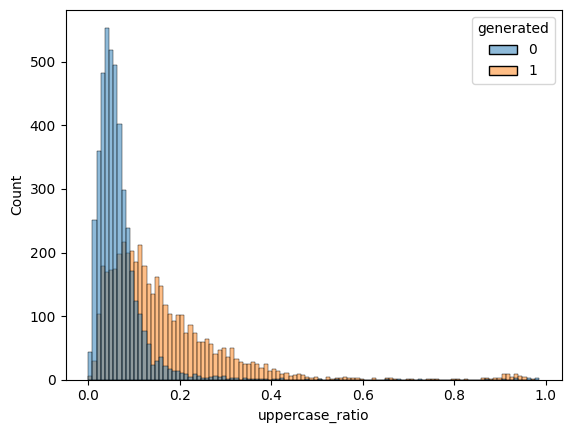

In [48]:
import seaborn as sns

sns.histplot(data=features_df, x="uppercase_ratio", hue="generated")

<Axes: xlabel='character_count', ylabel='Count'>

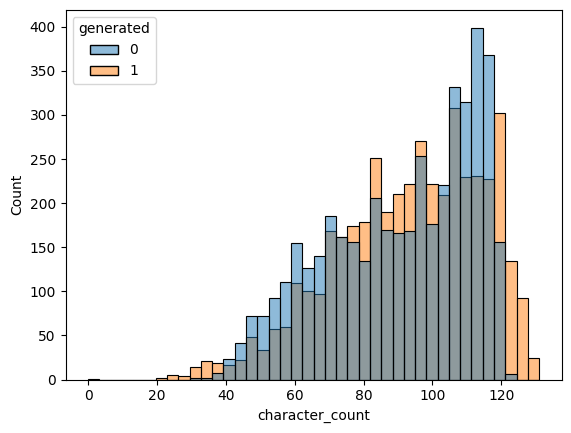

In [49]:
sns.histplot(data=features_df, x="character_count", hue="generated")

<Axes: xlabel='word_count', ylabel='Count'>

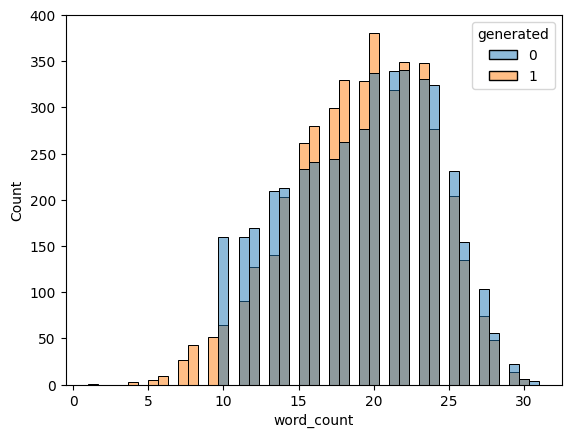

In [51]:
sns.histplot(data=features_df, x="word_count", hue="generated")

<Axes: xlabel='avg_word_length', ylabel='Count'>

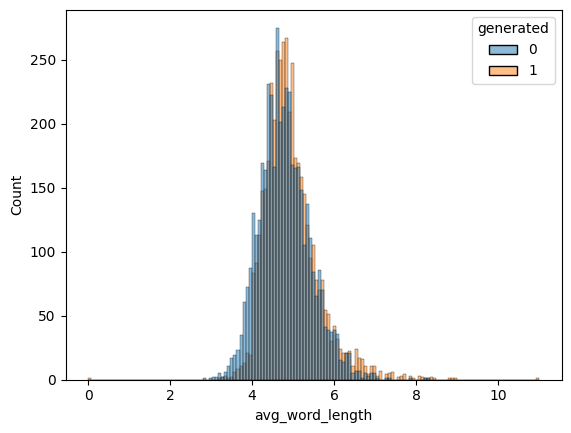

In [53]:
sns.histplot(data=features_df, x="avg_word_length", hue="generated")

## First modelisation

With not much work, can we already perform a classification ?

**Task** : Train a [`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) with a [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) in a [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). We shall use the [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) function to measure performance. Here, we'll use the [`f1_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) metric, so we will probably need the [`make_scorer`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) function.
Bonus: use a [`TunedThresholdClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TunedThresholdClassifierCV.html).


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [70]:
X = features_df[["uppercase_ratio", "character_count", "word_count", "avg_word_length"]]
X.head()

,uppercase_ratio,character_count,word_count,avg_word_length
0,0.063492,63,15,4.200000
1,0.152174,91,21,4.333333
2,0.101010,99,19,5.210526
3,0.377358,52,9,5.777778
4,0.315789,56,13,4.307692


In [71]:
y = features_df["generated"]
y.head()

0    0
1    1
2    1
3    1
4    1
Name: generated, dtype: int64

In [76]:
pipe = Pipeline(steps=[("scaler", StandardScaler()), ("model", LogisticRegression())])

scores = cross_val_score(pipe, X, y)
print(scores)

[0.76853424 0.77136389 0.76683645 0.75891341 0.74985852]


Already quite good performance without using the text _directly_.

## NLP modelisation

But it should be better with it.

**Task** : Still using a [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) class and the [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) function, now use the [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) class with english stopwords and display results.


In [96]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [97]:
pipe = Pipeline(steps=[("model", LogisticRegression())])

corpus = features_df["content"]
vectorizer = TfidfVectorizer(stop_words="english")
X_words = vectorizer.fit_transform(corpus)
scores = cross_val_score(pipe, X_words, y)
print(scores)

[0.91114884 0.91341256 0.91341256 0.90039615 0.9049236 ]


That is better ! But we could imagine stronger performance if we tuned a bit the vectorizer.

**Task** : Using the [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) class, find better parameter for the vectorizer.


In [98]:
from sklearn.model_selection import GridSearchCV

In [118]:
pipe = Pipeline(
    steps=[("vectorizer", TfidfVectorizer()), ("model", LogisticRegression())]
)

param_grid = {"vectorizer__stop_words": ["english", None]}

grid = GridSearchCV(pipe, param_grid)

corpus = features_df["content"]
results = grid.fit(corpus, y)

In [119]:
print(results.cv_results_)

{'mean_fit_time': array([0.08694043, 0.08939786]), 'std_fit_time': array([0.00407035, 0.00245082]), 'mean_score_time': array([0.01472101, 0.01601243]), 'std_score_time': array([0.00040269, 0.00070234]), 'param_vectorizer__stop_words': masked_array(data=['english', None],
             mask=[False, False],
       fill_value=np.str_('?'),
            dtype=object), 'params': [{'vectorizer__stop_words': 'english'}, {'vectorizer__stop_words': None}], 'split0_test_score': array([0.9196378 , 0.92756084]), 'split1_test_score': array([0.91624222, 0.91794001]), 'split2_test_score': array([0.91624222, 0.92359932]), 'split3_test_score': array([0.90209394, 0.90605546]), 'split4_test_score': array([0.90831919, 0.91511036]), 'mean_test_score': array([0.91250707, 0.9180532 ]), 'std_test_score': array([0.00639877, 0.00739964]), 'rank_test_score': array([2, 1], dtype=int32)}


But we only used words this time, not the previous statistics we had.

## Third modelisation : combining approach

**Task** : Using the [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html#sklearn.compose.ColumnTransformer), rewrite the pipeline so that it uses both numeric and text features.

As the [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) expect 1D array, one need to use first [`FunctionTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html#sklearn.preprocessing.FunctionTransformer) to flatten the input using the `squeeze` method.


It is better ! Time to fit it, then use the test set and submit on the [Kaggle competition](https://www.kaggle.com/t/db2bae0e9d814baa96a0468f021cd3f2).

**Task** : Rewrite your feature engineering pipeline and use it to submit.


Now, it is up to you to make the performance better ! Here are some guidelines:

1. Make the dataset _cleaner_ : there are probably still some work to do
2. Build better features : more useful statistics can be extracted
3. Find the most suitable model : note that we didn't fine-tune it, only the vectorizer...
